In [1]:
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import TypedDict, Literal, Annotated, Dict, List
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import  ChatGroq

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="qwen-2.5-32b")
output_parser = StrOutputParser()

In [2]:
# Graph state
class EmailState(TypedDict):
    description: str
    email_content: str
    category: str
    status: str
    response: str

In [3]:
def generate_email(state:EmailState) -> EmailState:
    """Generate the email based on the description"""
    email_response = llm.invoke(
        f""" Generate a realistic email based on the following description:
        Description: {state["description"]}
        Generate the email content includes subject and body.
        """
    )
    return {"email_content":email_response.content}

In [4]:
def classify_email(state: EmailState) -> EmailState:
    """Classify the email content to determine which team to handle"""
    category_response = llm.invoke(
        f""" Analyse the email and determine which team it should handle
        Options are: "manager", "technical_team" or "marketing_team"
        Email:{state["email_content"]}
        """
    )
    return {"category_response":category_response}

In [5]:
def manger_handler(state: EmailState) -> EmailState:
    """Handles the email directed from management team"""
    manager_response = llm.invoke(
        f""" you are a management assistant. Craft a professional response to the email:
        Email: {state['email_content']}
        Your response:
        """
    )

    return {"response":manager_response.content, "status":"Completed by manager"}

In [6]:
def technical_handler(state: EmailState) -> EmailState:
    """Handles the email directed from technical support team"""
    technical_response = llm.invoke(
        f""" you are a technical support specialist. Craft a professional response to the email:
        Email: {state['email_content']}
        Your response:
        """
    )

    return {"response":technical_response.content, "status":"Completed by technical"}

In [7]:
def marketing_handler(state: EmailState) -> EmailState:
    """Handles the email directed from marketing team"""
    marketing_response = llm.invoke(
        f""" you are a marketing specialist. Craft a engaging reply to the email:
        Email: {state['email_content']}
        Your response:
        """
    )

    return {"response":marketing_response.content, "status":"Completed by manager"}

In [12]:
def route_email(state:EmailState) -> Literal["manager","technical_team","marketing_team"]:
    """Route the email to the appropriate team based on its classification """
    category = state["category_response"]
    if "manager" in category:
        return "manager"
    elif "technical_team" in category:
        return "technical_team"
    else:
        return "marketing_team"

In [14]:
workflow = StateGraph(EmailState)

workflow.add_node("generator",generate_email)
workflow.add_node("classifier",classify_email)
workflow.add_node("manager",manger_handler)
workflow.add_node("technical_team",technical_handler)
workflow.add_node("marketing_team",marketing_handler)

workflow.add_edge(START,"generator")
workflow.add_edge("generator","classifier")
workflow.add_conditional_edges(
    "classifier",
    route_email,
    {"manager": "manager",
    "technical_team": "technical_team",
    "marketing_team": "marketing_team"}
)
workflow.add_edge("manager",END)
workflow.add_edge("technical_team",END)
workflow.add_edge("marketing_team",END)

graph = workflow.compile()


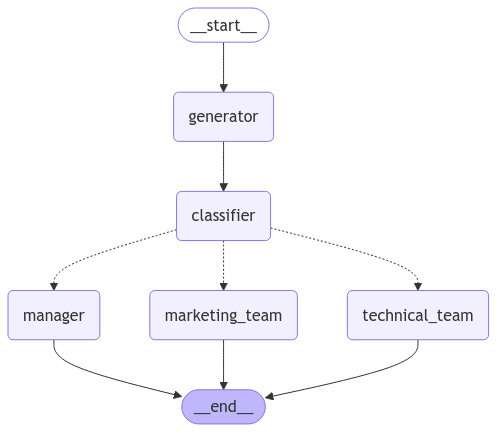

In [15]:
from IPython.display import display,Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
response = graph.invoke({"description":"Manager needs approval for which the budget is $50000"},{'recursion_limit':100})
response

{'description': 'Manager needs approval for which the budget is $50000',
 'email_content': "**Subject:** Request for Approval of Budget Allocation - Project XYZ\n\n**Body:**\n\nDear [Recipient's Name],\n\nI hope this message finds you well. I am writing to request your approval for the allocation of a budget amounting to $50,000 for our upcoming project, XYZ. This budget is crucial for ensuring the project's success by covering key aspects such as personnel, equipment, and supplies.\n\nThe breakdown of the budget is as follows:\n- Personnel: $25,000\n- Equipment: $15,000\n- Supplies: $10,000\n\nThis funding will enable us to meet our project objectives on time and within the scope agreed upon. Please find attached a detailed budget proposal that outlines the specific cost items and their justifications.\n\nCould you kindly review the attached document and provide your approval at your earliest convenience? Your support in this matter is greatly appreciated.\n\nThank you for considering